<a href="https://colab.research.google.com/github/hamisB/machine-learning/blob/master/Baby_Weights_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages & Data 



In [0]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling as pp
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Import Data from BigQuery 
data = pd.io.gbq.read_gbq(
'''
SELECT
  source_year,
  is_male,
  ROUND(weight_pounds * 0.453592,2) as weightbabykg,
  plurality,
  CASE 
     WHEN mother_race=1 THEN "White" 
     WHEN mother_race=2 THEN "Black" 
     WHEN mother_race=3 THEN "American Indian" 
     WHEN mother_race=4 THEN "Chinese" 
     WHEN mother_race=5 THEN "Japanese" 
     WHEN mother_race=6 THEN "Hawaiian"
     WHEN mother_race=7 THEN "Filipino"
     WHEN mother_race=18 THEN "Asian Indian"
     WHEN mother_race=28 THEN "Korean"
     WHEN mother_race=39 THEN "Samoan"
     WHEN mother_race=48 THEN "Vietnamese"     
    ELSE "Unknown/Other" END AS mother_race,
  mother_age,
  gestation_weeks,
  mother_married,
  cigarette_use,
  alcohol_use,
  ROUND(weight_gain_pounds * 0.453592,2) as mother_weight,
  ever_born,
    CASE 
     WHEN father_race=1 THEN "White" 
     WHEN father_race=2 THEN "Black" 
     WHEN father_race=3 THEN "American Indian" 
     WHEN father_race=4 THEN "Chinese" 
     WHEN father_race=5 THEN "Japanese" 
     WHEN father_race=6 THEN "Hawaiian"
     WHEN father_race=7 THEN "Filipino"
     WHEN father_race=18 THEN "Asian Indian"
     WHEN father_race=28 THEN "Korean"
     WHEN father_race=39 THEN "Samoan"
     WHEN father_race=48 THEN "Vietnamese"     
    ELSE "Unknown/Other" END AS father_race,
  father_age
FROM
  `bigquery-public-data.samples.natality`
WHERE
  source_year = 2008 AND mother_race is not null AND weight_pounds is not null
  LIMIT 150000

'''
, project_id="t-water-211708", dialect='standard')

### Data Cleaning

In [0]:
#Checking the data
data.head ()

,source_year,is_male,weightbabykg,plurality,mother_race,mother_age,gestation_weeks,mother_married,cigarette_use,alcohol_use,mother_weight,ever_born,father_race,father_age
0,2008,False,2.69,1,White,44,36.0,True,False,False,16.33,8.0,White,43
1,2008,False,2.48,1,White,32,33.0,False,False,False,9.07,8.0,White,30
2,2008,False,3.74,1,White,27,37.0,True,False,False,18.14,8.0,White,34
3,2008,False,3.20,1,White,42,39.0,True,False,False,NaN,8.0,White,41
4,2008,False,3.60,1,White,41,38.0,True,False,False,9.07,8.0,White,31


In [0]:
#Get data information & type of variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   source_year      150000 non-null  int64  
 1   is_male          150000 non-null  bool   
 2   weightbabykg     150000 non-null  float64
 3   plurality        150000 non-null  int64  
 4   mother_race      150000 non-null  object 
 5   mother_age       150000 non-null  int64  
 6   gestation_weeks  149884 non-null  float64
 7   mother_married   150000 non-null  bool   
 8   cigarette_use    149639 non-null  object 
 9   alcohol_use      149639 non-null  object 
 10  mother_weight    147565 non-null  float64
 11  ever_born        149661 non-null  float64
 12  father_race      150000 non-null  object 
 13  father_age       150000 non-null  int64  
dtypes: bool(2), float64(4), int64(4), object(4)
memory usage: 14.0+ MB


In [0]:
#Check the unique value of each column
for i , col in enumerate(data):
  print (f"Unique value of {col} : {data[col].nunique()}")

Unique value of source_year : 1
Unique value of is_male : 2
Unique value of weightbabykg : 518
Unique value of plurality : 5
Unique value of mother_race : 11
Unique value of mother_age : 39
Unique value of gestation_weeks : 31
Unique value of mother_married : 2
Unique value of cigarette_use : 2
Unique value of alcohol_use : 2
Unique value of mother_weight : 99
Unique value of ever_born : 8
Unique value of father_race : 11
Unique value of father_age : 63


In [0]:
#Then drop source_year 
data.drop('source_year', axis=1, inplace=True)

In [0]:
#Copy data to dataset
dataset = data.copy()

In [0]:
#Checking null values 
((dataset.isna().sum()/len(dataset))*100).reset_index().rename(columns={'index':'variable', 0:'%N/A'}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
variable,is_male,weightbabykg,plurality,mother_race,mother_age,gestation_weeks,mother_married,cigarette_use,alcohol_use,mother_weight,ever_born,father_race,father_age
%N/A,0,0,0,0,0,0.0773333,0,0.240667,0.240667,1.62333,0.226,0,0


In [0]:
#Clean the mother weight & ever born 
dataset['mother_weight'].fillna(dataset['mother_weight'].mean())
dataset['ever_born'].fillna(dataset['ever_born'].mean())

#Then clean all the null row with null categorical varibale 
dataset.dropna(axis=0, inplace=True)

#Then check the % missing value 
((dataset.isna().sum()/len(dataset))*100).reset_index().rename(columns={'index':'variable', 0:'%N/A'}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
variable,is_male,weightbabykg,plurality,mother_race,mother_age,gestation_weeks,mother_married,cigarette_use,alcohol_use,mother_weight,ever_born,father_race,father_age
%N/A,0,0,0,0,0,0,0,0,0,0,0,0,0


### Data Analysis

In [0]:
# Summary of the dataset
dataset.describe()

,weightbabykg,plurality,mother_age,gestation_weeks,mother_weight,ever_born,father_age
count,146834.000000,146834.000000,146834.000000,146834.000000,146834.000000,146834.000000,146834.000000
mean,3.255568,1.037655,27.337395,38.572572,14.891228,1.986182,41.078483
std,0.595243,0.200807,6.149334,2.569944,7.996221,1.177466,25.514047
min,0.230000,1.000000,12.000000,17.000000,0.450000,1.000000,10.000000
25%,2.950000,1.000000,22.000000,38.000000,9.980000,1.000000,26.000000
50%,3.290000,1.000000,27.000000,39.000000,13.610000,2.000000,32.000000
75%,3.630000,1.000000,32.000000,40.000000,18.140000,2.000000,39.000000
max,5.980000,5.000000,50.000000,47.000000,44.910000,8.000000,99.000000


In [0]:
dataset.columns

Index(['is_male', 'weightbabykg', 'plurality', 'mother_race', 'mother_age',
       'gestation_weeks', 'mother_married', 'cigarette_use', 'alcohol_use',
       'mother_weight', 'ever_born', 'father_race', 'father_age'],
      dtype='object')

,is_male,weightbabykg,plurality,mother_age,gestation_weeks,mother_married,mother_weight,ever_born,father_age
mother_race,,,,,,,,,
American Indian,0.509263,3.313100,1.028818,25.020996,38.548786,0.354879,15.045438,2.291478,43.792507
Asian Indian,0.525412,3.119396,1.038462,29.969093,38.596841,0.979396,13.842885,1.609890,34.210165
Black,0.500412,3.069787,1.038130,25.323332,38.168880,0.268232,14.609191,2.106083,53.917511
Chinese,0.523752,3.271778,1.025579,32.222899,38.784409,0.912302,13.982497,1.609013,36.556638
Filipino,0.510107,3.175149,1.026159,31.008323,38.409037,0.822830,15.264935,1.882283,37.613555
Hawaiian,0.485294,3.103088,1.000000,24.705882,37.941176,0.441176,16.803529,2.014706,38.838235
Japanese,0.423077,3.142756,1.057692,33.474359,38.756410,0.961538,12.709551,1.634615,34.698718
Korean,0.507645,3.274893,1.024465,32.272171,39.018349,0.951070,15.761009,1.712538,35.003058
Unknown/Other,0.529305,3.167420,1.035650,29.379758,38.595468,0.845317,14.321864,1.836254,36.321752


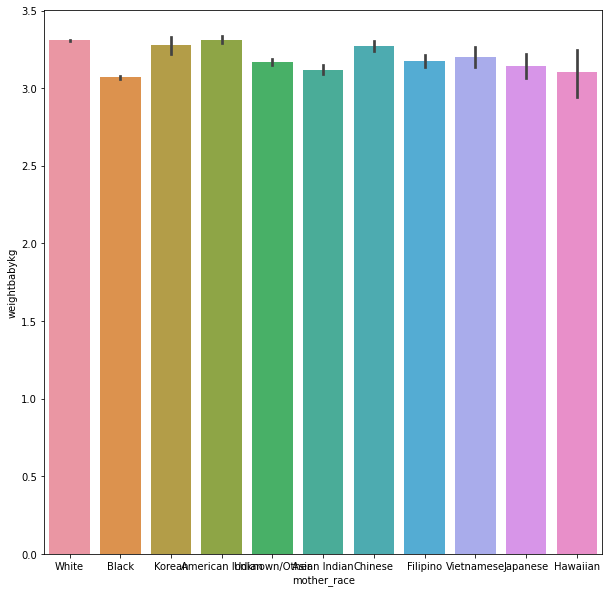

In [0]:
# Aggrage data by Mother Race 
plt.figure(figsize=(10,10))
sns.barplot(x='mother_race', y='weightbabykg', data=dataset )
dataset.groupby('mother_race').mean()

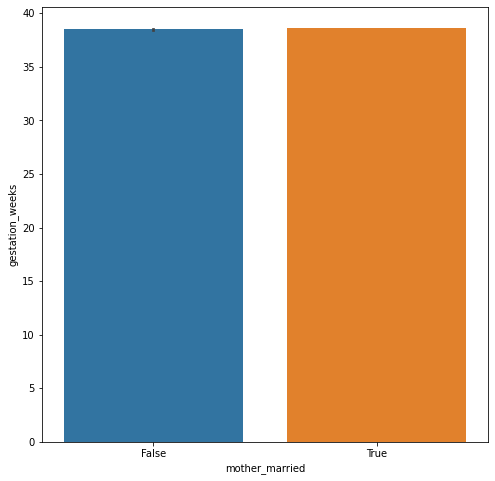

In [0]:
plt.figure(figsize=(8,8))
sns.barplot(x='mother_married', y='gestation_weeks', data=dataset )
plt.show()

In [0]:
#Aggrage data by Mother marital status
dataset.groupby('mother_married').mean()

,is_male,weightbabykg,plurality,mother_age,gestation_weeks,mother_weight,ever_born,father_age
mother_married,,,,,,,,
False,0.507598,3.169748,1.026909,23.972723,38.484275,15.104117,1.907612,53.183017
True,0.511537,3.314339,1.045014,29.641599,38.633039,14.745436,2.039988,32.789021


In [0]:
#Aggrage data by baby is male
dataset.groupby('is_male').mean()

,weightbabykg,plurality,mother_age,gestation_weeks,mother_married,mother_weight,ever_born,father_age
is_male,,,,,,,,
False,3.199034,1.037411,27.320868,38.628089,0.591595,14.732851,1.982837,41.251369
True,3.309899,1.037889,27.353277,38.519218,0.595398,15.043432,1.989396,40.912335


In [0]:
#Creating a sub dataset only with numerical columns
dataset_num = dataset.select_dtypes(include=['int', 'float'])

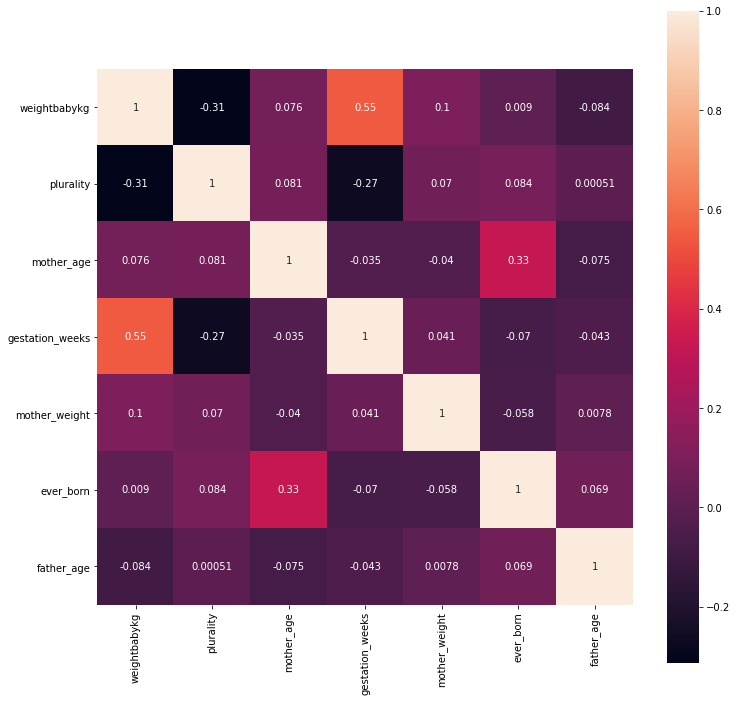

In [0]:
#Checking correlation of the data
plt.figure(figsize=(12,12))
sns.heatmap(dataset_num.corr(),annot=True , square=True)

#plt.show()

### Data Preprocessing

In [0]:
# Bool to Object for variables : is_male & mother_married
dataset_ml = dataset.drop(['father_race','father_age','mother_race','ever_born'], axis=1)
dataset_ml['is_male']=dataset_ml['is_male'].astype('str')
dataset_ml['mother_married']=dataset_ml['mother_married'].astype('str')
dataset_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146834 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   is_male          146834 non-null  object 
 1   weightbabykg     146834 non-null  float64
 2   plurality        146834 non-null  int64  
 3   mother_age       146834 non-null  int64  
 4   gestation_weeks  146834 non-null  float64
 5   mother_married   146834 non-null  object 
 6   cigarette_use    146834 non-null  object 
 7   alcohol_use      146834 non-null  object 
 8   mother_weight    146834 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 16.2+ MB


In [0]:
# Import all the packages 
from sklearn.preprocessing import OneHotEncoder , LabelBinarizer , StandardScaler , Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression , SGDRegressor , Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse ,r2_score 
from sklearn.model_selection import cross_val_score , GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


In [0]:
# Gathering variables by typolog
numeric_features = dataset_ml.select_dtypes(include=['int64', 'float64']).drop(['weightbabykg'], axis=1).columns
categorical_features = dataset_ml.select_dtypes(include=['object']).columns
print(f"numeric_features :  {numeric_features} \n ============================================================================================  ")
print(f"categorical_features :  {categorical_features} \n ============================================================================================  ")

numeric_features :  Index(['plurality', 'mother_age', 'gestation_weeks', 'mother_weight'], dtype='object') 
categorical_features :  Index(['is_male', 'mother_married', 'cigarette_use', 'alcohol_use'], dtype='object') 


In [0]:
# Create training and testing dataset 
X = dataset_ml.drop('weightbabykg', axis=1)
Y = dataset_ml['weightbabykg']
x_train, x_test, y_train, y_test = train_test_split( X, Y , test_size=0.20 , random_state=42 )
print (f" Shape of train dataset : {x_train.shape} \n ======================== ")
print (f" Shape of test dataset : {x_test.shape} \n")

 Shape of train dataset : (117467, 8) 
 Shape of test dataset : (29367, 8) 



In [0]:
# Numeric transformation
numeric_transformer = Pipeline(steps=[('normalizer', Normalizer() ), ('scaler', StandardScaler() )])

# Categorical transformation
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])


# Preprocessor for linear model
Linear_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features) ])

# Preprocessor for other type of model
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

### Modelisation

In [0]:
# Linear Model Pipeline
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression() ) ] )
lr_model.fit(x_train, y_train)

In [0]:
# Modeling function 
def print_linear_score(model):
  modeling = Pipeline(steps=[('preprocessor', Linear_preprocessor),
                      ('regressor', model) ] )
  modeling.fit(x_train, y_train)
  y_pred=modeling.predict(x_test)
  model_name=type(model).__name__
  print(f"The score of {model_name} is : { round(r2_score(y_test, y_pred),2) } \n==================================")
  print(f"The MSE of {model_name} is : { round( mse(y_test, y_pred),2) } \n================================== ")
  print (f"The MAE of {model_name} is : { round(mae(y_test, y_pred), 2) } \n==================================")


In [0]:
print_linear_score(LinearRegression())

The score of LinearRegression is : 0.27 
The MSE of LinearRegression is : 0.26 
The MAE of LinearRegression is : 0.39 


In [0]:
print_linear_score(SGDRegressor())

The score of SGDRegressor is : 0.27 
The MSE of SGDRegressor is : 0.26 
The MAE of SGDRegressor is : 0.39 


In [0]:
# Modeling function 
def print_score(model):
  modeling = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', model) ] )
  modeling.fit(x_train, y_train)
  y_pred=modeling.predict(x_test)
  model_name=type(model).__name__
  print(f"The score of {model_name} is : { round ( r2_score(y_test, y_pred), 2) } \n==================================")
  print(f"The MSE of {model_name} is : { round ( mse(y_test, y_pred), 2) } \n================================== ")
  print (f"The MAE of {model_name} is : { round ( mae(y_test, y_pred), 2) } \n==================================")

In [0]:
print_score(RandomForestRegressor())

The score of RandomForestRegressor is : 0.03 
The MSE of RandomForestRegressor is : 0.35 
The MAE of RandomForestRegressor is : 0.43 


In [0]:
print_score(DecisionTreeRegressor(criterion='mse', max_depth=100 , random_state= 123))

The score of DecisionTreeRegressor is : 0.03 
The MSE of DecisionTreeRegressor is : 0.35 
The MAE of DecisionTreeRegressor is : 0.43 


### XGBoost Modelisation

In [0]:
import xgboost as xgb

print_score( xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10) )

[13:18:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The score of XGBRegressor is : -2.55 
The MSE of XGBRegressor is : 1.27 
The MAE of XGBRegressor is : 1.02 


All the models are are quit good , lower score and greater MSE , MAE & RMSE

We'll try dive in feature engineering to select only the features that matter for the model. 

In [0]:
# Dataset 
dataset.head()
dataset_lasso = pd.get_dummies(dataset_ml)
x_lasso = dataset_lasso.drop('weightbabykg', axis=1)
y_lasso = dataset_lasso['weightbabykg']

[-0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0. -0.]


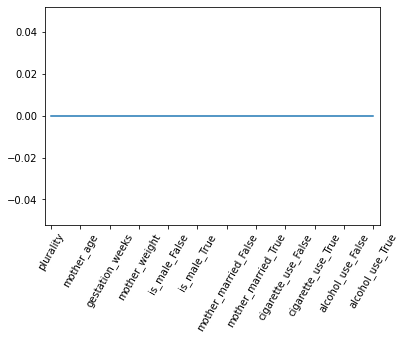

In [0]:
# Fit the regressor to the data
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(x_lasso, y_lasso)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(x_lasso.columns)), lasso_coef)
plt.xticks(range(len(x_lasso.columns)), x_lasso.columns.values, rotation=60)
plt.margins(0.02)
plt.show()

In [0]:
pd.DataFrame(lasso_coef, index=x_lasso.columns)

,0
plurality,-0.0
mother_age,0.0
gestation_weeks,0.0
mother_weight,0.0
is_male_False,-0.0
is_male_True,0.0
mother_married_False,-0.0
mother_married_True,0.0
cigarette_use_False,0.0
cigarette_use_True,-0.0
